In [33]:
!git clone https://github.com/danilkos00/PyTorch-Detector.git
%cd PyTorch-Detector
!pip install -r requirements.txt -qq

Cloning into 'PyTorch-Detector'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 44 (delta 15), reused 42 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (44/44), 11.79 KiB | 215.00 KiB/s, done.
Resolving deltas: 100% (15/15), done.
/content/PyTorch-Detector


In [34]:
import torch
from torch.utils import data

In [35]:
from dataset.faces import FacesDataset


datasets = {'train' : FacesDataset(train=True),
            'val' : FacesDataset(train=False)}

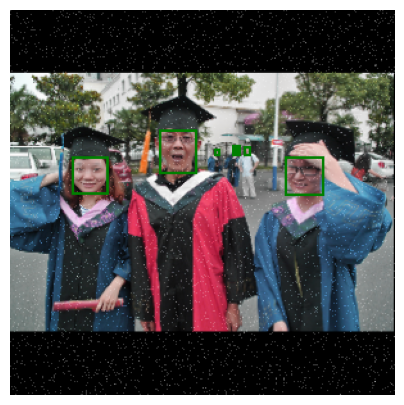

In [36]:
from tools.detection_utils import imshow

img, boxes, cls = datasets['train'][2]
imshow(img, boxes, 'green', box_width=2)

In [37]:
import gdown


url = 'https://drive.google.com/uc?id=1TTPEvt2OpJ6hm0uBnTrv2f0xo1960PNL'
output_path = './params.tar'
gdown.download(url, output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1TTPEvt2OpJ6hm0uBnTrv2f0xo1960PNL
From (redirected): https://drive.google.com/uc?id=1TTPEvt2OpJ6hm0uBnTrv2f0xo1960PNL&confirm=t&uuid=10bf7f80-0392-4c16-9976-71bfc6891b34
To: /content/PyTorch-Detector/params.tar
100%|██████████| 221M/221M [00:18<00:00, 11.7MB/s]


'./params.tar'

In [38]:
from src.model import DetectorSSD

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DetectorSSD(num_classes=1)

model.load_state_dict(torch.load('params.tar', weights_only=True, map_location=device))

model.to(device);

In [39]:
def collate_fn(batch):
    images, bboxes, classes = zip(*batch)
    images = torch.stack(images)
    return images, list(bboxes), list(classes)

dataloaders = {'train' : data.DataLoader(datasets['train'], 32, shuffle=True, collate_fn=collate_fn, num_workers=2, pin_memory=True, drop_last=True),
               'val' : data.DataLoader(datasets['val'], 32, shuffle=False, collate_fn=collate_fn, num_workers=2, pin_memory=True)}

In [40]:
from tools.train import train_model

num_epochs = 1
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-3)

In [41]:
train_model(model, optimizer, dataloaders, num_epochs)

Epoch: 1/1
----------


100%|██████████| 418/418 [08:41<00:00,  1.25s/it, cls_loss=1.4088, gmax=3.5621e-01, gnorm=4.6826e+00, loc_loss=0.5373, loss=1.9461, lr=1e-5]


train Epoch Loss: 1.9162, cls Loss: 1.4702, loc Loss: 0.4460


100%|██████████| 105/105 [01:00<00:00,  1.74it/s, cls_loss=1.2758, gmax=0.0000e+00, gnorm=0.0000e+00, loc_loss=0.5950, loss=1.8708, lr=1e-5]


val Epoch Loss: 2.0955, cls Loss: 1.4525, loc Loss: 0.6430; mAP: 0.2418; mAP_50: 0.3543
----------
Training completed in 9m 44s


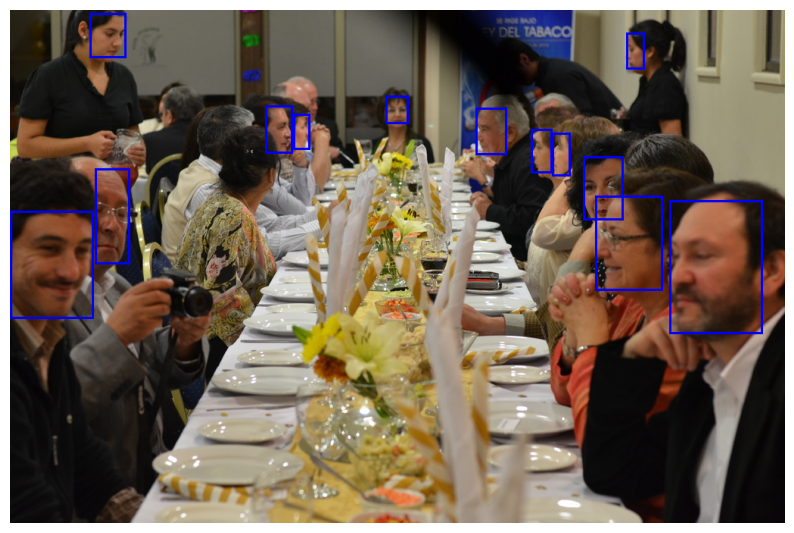

In [43]:
from tools.detection_utils import resize_back, nms


inf_dataset = FacesDataset(train=False, return_original_img=True)
images, bboxes, classes, original_image = inf_dataset[114]
bboxes = bboxes.to(device)
classes = classes.to(device)

with torch.no_grad():
    model.eval()
    outputs = model(images.unsqueeze(0).to(device))
    original_bboxes = resize_back(bboxes, original_image.size()[1:])
    imshow(original_image, original_bboxes, 'blue', (10, 10), 3)

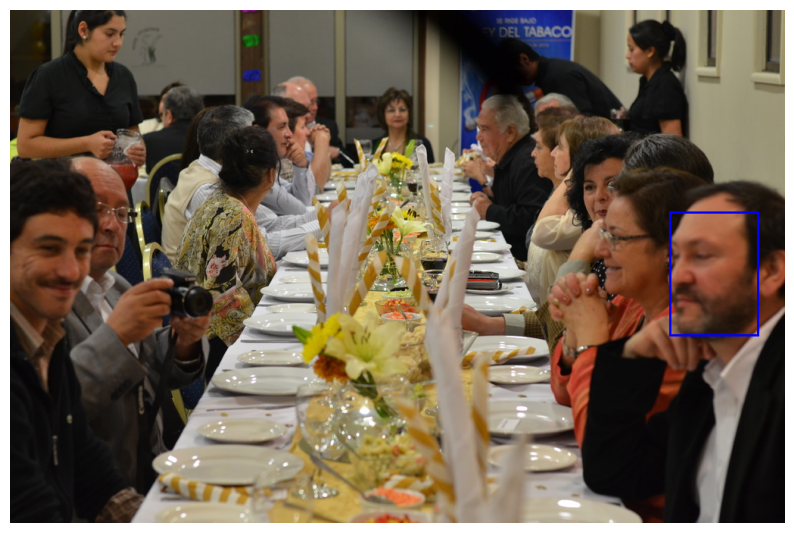

In [44]:
original_bboxes = resize_back(nms(outputs['pred_loc'], outputs['pred_classes'], 0.2, 0.5)[0]['boxes'], original_image.size()[1:])
imshow(original_image, original_bboxes, 'blue', (10,10), 3)

In [45]:
# from tools.detection_utils import show_preds

show_preds(model, datasets['val'], num_images=10)

Output hidden; open in https://colab.research.google.com to view.